## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=notebooks/tutorials/mapping-fires.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Use `OWSLib` to determine what data is available and inspect the metadata
   2. Use `OWSLib` to filter and read the data
   3. Use `geopandas` and `folium` to analyze and plot the data

Note that the default examples environment is missing one requirement: `oswlib`. We can `pip install` that before we move on. 

In [1]:
from owslib.ogcapi.features import Features
import geopandas as gpd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import pickle
import warnings

## About the Data


The fire data shown is generated by the FEDs algorithm. The FEDs algorithm tracks fire movement and severity by ingesting observations from the VIIRS thermal sensors on the Suomi NPP and NOAA-20 satellites. This algorithm uses raw VIIRS observations to generate a polygon of the fire, locations of the active fire line, and estimates of fire mean Fire Radiative Power (FRP). The VIIRS sensors overpass at ~1:30 AM and PM local time, and provide estimates of fire evolution ~ every 12 hours. The data produced by this algorithm describe where fires are in space and how fires evolve through time. This CONUS-wide implementation of the FEDs algorithm is based on [Chen et al 2020’s](https://www.nature.com/articles/s41597-022-01343-0) algorithm for California.


The data produced by this algorithm is considered experimental. 

## Look at the data that is available through the OGC API

The datasets that are distributed throught the OGC API are organized into collections.
We can display the collections with the command: 

In [2]:
OGC_URL = "https://firenrt.delta-backend.com"

w = Features(url=OGC_URL)
w.feature_collections()

['public.eis_fire_lf_perimeter_nrt',
 'public.eis_fire_snapshot_newfirepix_nrt',
 'public.eis_fire_snapshot_perimeter_pkey_test',
 'public.eis_fire_snapshot_fireline_nrt',
 'public.eis_fire_lf_nfplist_nrt',
 'public.eis_fire_lf_fireline_archive',
 'public.eis_fire_lf_perimeter_archive',
 'public.eis_fire_lf_newfirepix_nrt',
 'public.eis_fire_lf_fireline_nrt',
 'public.eis_fire_snapshot_perimeter_nrt',
 'public.eis_fire_lf_nfplist_archive',
 'public.eis_fire_lf_newfirepix_archive',
 'public.eis_public_snapshot_perimeter_testv2',
 'public.eis_fire_fwi',
 'public.st_squaregrid',
 'public.st_hexagongrid',
 'public.st_subdivide']

We will focus on the `public.eis_fire_snapshot_fireline_nrt` collection, the `public.eis_fire_snapshot_perimeter_nrt` collection, and the `public.eis_fire_lf_perimeter_archive` collection here. 

### Inspect the metatdata for public.eis_fire_snapshot_perimeter_nrt collection

We can access information that describes the `public.eis_fire_snapshot_perimeter_nrt` table. 

In [3]:
perm = w.collection("public.eis_fire_lf_perimeter_archive")
perm["extent"]

{'spatial': {'bbox': [[-125.01170994228654,
    31.67479552365894,
    -100.99882037044597,
    49.5160148262177]],
  'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'},
 'temporal': {'interval': [['2018-01-02T12:00:00+00:00',
    '2021-12-31T12:00:00+00:00']],
  'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}}

In addition to getting metadata about the data we can access the queryable fields. Each of these fields will represent a column in our dataframe.

In [4]:
perm_q = w.collection_queryables("public.eis_fire_lf_perimeter_archive")
perm_q["properties"]

{'wkb_geometry': {'$ref': 'https://geojson.org/schema/Geometry.json'},
 'duration': {'name': 'duration', 'type': 'number'},
 'farea': {'name': 'farea', 'type': 'number'},
 'fireid': {'name': 'fireid', 'type': 'string'},
 'flinelen': {'name': 'flinelen', 'type': 'number'},
 'fperim': {'name': 'fperim', 'type': 'number'},
 'meanfrp': {'name': 'meanfrp', 'type': 'number'},
 'n_newpixels': {'name': 'n_newpixels', 'type': 'number'},
 'n_pixels': {'name': 'n_pixels', 'type': 'number'},
 'ogc_fid': {'name': 'ogc_fid', 'type': 'number'},
 'pixden': {'name': 'pixden', 'type': 'number'},
 't': {'name': 't', 'type': 'string'}}

## Filter the data

In [5]:
start = "2020-06-01T00:00:00+00:00" #June through Nov 2020
end = "2020-12-01T00:00:00+00:00"

Start by finding the largest perimeters in this time period

In [6]:
perm_results = w.collection_items(
    "public.eis_fire_lf_perimeter_archive", 
    bbox=["-125", "31", "-102", "49.2"], #western us [-125,-102,31,49.2] 
    datetime=[start + "/" + end],  # date range
    limit=3000,  # max number of items returned
    filter="farea>400 AND duration>4",  # additional filters based on queryable fields
)

In [7]:
#variations of search for looking at specific fires
'''
perm_results = w.collection_items(
    "public.eis_fire_lf_perimeter_archive", 
    #bbox=["-121", "46", "-118", "49"], #riverside oregon
    bbox=["-122", "37", "-121", "37.7"], #scu lightning complex
    datetime=[start + "/" + end],  # date range
    limit=2000,  # max number of items returned
    filter="farea>1 AND duration>0",  # additional filters based on queryable fields
)
'''

'\nperm_results = w.collection_items(\n    "public.eis_fire_lf_perimeter_archive", \n    #bbox=["-121", "46", "-118", "49"], #riverside oregon\n    bbox=["-122", "37", "-121", "37.7"], #scu lightning complex\n    datetime=[start + "/" + end],  # date range\n    limit=2000,  # max number of items returned\n    filter="farea>1 AND duration>0",  # additional filters based on queryable fields\n)\n'

The result is a dictionary containing all of the data and some summary fields. We can look at the keys to see what all is in there.

In [8]:
perm_results.keys()

dict_keys(['type', 'id', 'title', 'description', 'numberMatched', 'numberReturned', 'links', 'features'])

In [9]:
perm_results['numberMatched'], perm_results["numberReturned"]

(2046, 2046)

The unique ids of the fire objects of interest:

In [10]:
fireids = [i['properties']['fireid'] for i in perm_results['features']]
fireids = np.unique(fireids)
fireids = str(tuple(fireids)) #need it as a string list of strings with parentheses for query
fireids

"('F10523', 'F10547', 'F11247', 'F11393', 'F11440', 'F11445', 'F11527', 'F11529', 'F11716', 'F11825', 'F11921', 'F12380', 'F12649', 'F12731', 'F12774', 'F12822', 'F12961', 'F12981', 'F12984', 'F13066', 'F13515', 'F13687', 'F15118', 'F7823', 'F8251')"

Redo search for these 25 large fires, grabbing all associated perimeters and time stamps so that we get an accurate start date for them

In [11]:
perm_results = w.collection_items(
    "public.eis_fire_lf_perimeter_archive", 
    limit=3000, 
    filter="fireid IN " + fireids, 
)

You can also access the data directly in the browser or in an HTTP GET call using the constructed link.

In [13]:
perm_results["links"][1]["href"]

'https://firenrt.delta-backend.com/collections/public.eis_fire_lf_perimeter_archive/items?limit=3000&filter=fireid+IN+%28%27F10523%27%2C+%27F10547%27%2C+%27F11247%27%2C+%27F11393%27%2C+%27F11440%27%2C+%27F11445%27%2C+%27F11527%27%2C+%27F11529%27%2C+%27F11716%27%2C+%27F11825%27%2C+%27F11921%27%2C+%27F12380%27%2C+%27F12649%27%2C+%27F12731%27%2C+%27F12774%27%2C+%27F12822%27%2C+%27F12961%27%2C+%27F12981%27%2C+%27F12984%27%2C+%27F13066%27%2C+%27F13515%27%2C+%27F13687%27%2C+%27F15118%27%2C+%27F7823%27%2C+%27F8251%27%29'

## Read data

In addition to all the summary fields, the `perm_results` dict contains all the data. We can pass the data into geopandas to make it easier to interact with.

In [14]:
df = gpd.GeoDataFrame.from_features(perm_results["features"])
df

geometry  duration       farea  \
0     POLYGON ((-102.72753 32.08301, -102.72753 32.0...       7.0   21.698325   
1     POLYGON ((-102.72753 32.08301, -102.72753 32.0...       7.0   21.698325   
2     POLYGON ((-102.72753 32.08301, -102.72753 32.0...       7.0   21.698325   
3     POLYGON ((-102.72753 32.08301, -102.72753 32.0...       7.0   21.698325   
4     POLYGON ((-102.72753 32.08301, -102.72753 32.0...       7.0   21.698325   
...                                                 ...       ...         ...   
2937  POLYGON ((-117.96407 34.31855, -117.96407 34.3...      14.5  522.941236   
2938  POLYGON ((-117.96407 34.31855, -117.96407 34.3...      14.0  517.247601   
2939  POLYGON ((-117.96406 34.31854, -117.96407 34.3...      13.5  499.272560   
2940  POLYGON ((-117.95062 34.30073, -117.95062 34.3...      13.0  473.801000   
2941  POLYGON ((-117.95062 34.30073, -117.95062 34.3...      12.5  463.613181   

      fireid   flinelen      fperim    meanfrp  n_newpixels  n_pixels  \
0     F11716   0.000000   23.513195   0.000000            0        17   
1     F11716   0.000000   23.513195   0.000000            0        17   
2     F11716   0.000000   23.513195   0.000000            0        17   
3     F11716   0.000000   23.513195   0.000000            0        17   
4     F11716   0.000000   23.513195   0.000000            0        17   
...      ...        ...         ...        ...          ...       ...   
2937  F12731  15.244256  153.837582   5.262747           91      5560   
2938  F12731  18.558864  151.700270  61.837085          247      5469   
2939  F12731  36.864951  153.757488   6.965646          294      5222   
2940  F12731  22.046907  147.471897  55.945643          140      4928   
2941  F12731  62.206925  144.464392   4.862541          673      4788   

      ogc_fid     pixden                    t  
0        6206   0.783471  2018-09-09T00:00:00  
1        6207   0.783471  2018-09-26T00:00:00  
2        6208   0.783471  2018-09-24T00:00:00  
3        6209   0.783471  2018-09-09T12:00:00  
4        6210   0.783471  2018-09-16T12:00:00  
...       ...        ...                  ...  
2937   122536  10.632170  2020-09-21T00:00:00  
2938   122537  10.573273  2020-09-20T12:00:00  
2939   122538  10.459217  2020-09-20T00:00:00  
2940   122539  10.400991  2020-09-19T12:00:00  
2941   122540  10.327575  2020-09-19T00:00:00  

[2942 rows x 12 columns]

Keep only the largest perimeter of each fire ID, keeping track of start and end dates

In [15]:
warnings.filterwarnings('ignore', category=FutureWarning)

large_fires = gpd.GeoDataFrame()

fids = np.unique(df.fireid)
for fid in fids:
    subset = df[df.fireid==fid]
    startdate = subset.t.min()
    enddate = subset.t.max()

    row = subset.sort_values('farea', ascending=False).iloc[0,:]
    row['startdate'] = startdate
    row['enddate'] = enddate
    large_fires = large_fires.append(row, ignore_index=True)

large_fires = large_fires[['geometry','farea','fireid','startdate','enddate']] #only need these columns
large_fires = gpd.GeoDataFrame(large_fires).set_index('fireid')
large_fires

geometry        farea  \
fireid                                                                   
F10523  POLYGON ((-123.56713 41.18638, -123.56712 41.1...   659.981627   
F10547  MULTIPOLYGON (((-108.58554 39.29857, -108.5855...   590.420974   
F11247  POLYGON ((-105.89877 40.61373, -105.89869 40.6...   444.864376   
F11393  POLYGON ((-121.37461 37.38389, -121.37456 37.3...  1526.054850   
F11440  MULTIPOLYGON (((-121.52187 44.78768, -121.5218...  1894.388484   
F11445  POLYGON ((-122.59844 39.56282, -122.59844 39.5...  4493.471804   
F11527  POLYGON ((-120.85137 39.92894, -120.85124 39.9...  1400.560920   
F11529  MULTIPOLYGON (((-122.30420 38.74341, -122.3024...  1264.748675   
F11716  POLYGON ((-121.66228 36.14966, -121.66229 36.1...   521.979047   
F11825  POLYGON ((-118.45834 36.26310, -118.45836 36.2...   934.392811   
F11921  MULTIPOLYGON (((-110.74976 40.73822, -110.7495...   455.321311   
F12380  POLYGON ((-122.59663 44.79849, -122.59130 44.8...   551.940159   
F12649  POLYGON ((-119.48839 37.37486, -119.48839 37.3...  1768.278704   
F12731  POLYGON ((-117.96422 34.31876, -117.96422 34.3...   558.087422   
F12774  MULTIPOLYGON (((-119.60624 48.23640, -119.6071...  1016.807124   
F12822  POLYGON ((-116.90784 44.80170, -116.90783 44.8...   481.957725   
F12961  MULTIPOLYGON (((-122.30510 45.15745, -122.3045...   622.110247   
F12981  MULTIPOLYGON (((-122.23411 44.15412, -122.2341...   804.268938   
F12984  POLYGON ((-122.74770 43.36897, -122.74768 43.3...   597.782801   
F13066  MULTIPOLYGON (((-123.51933 41.92522, -123.5223...   751.547542   
F13515  MULTIPOLYGON (((-105.69394 40.76722, -105.6939...   591.899234   
F13687  POLYGON ((-106.26332 41.19634, -106.26328 41.1...   772.647843   
F15118  MULTIPOLYGON (((-106.00993 40.31399, -106.0097...   769.787819   
F7823   POLYGON ((-110.87566 32.44642, -110.87549 32.4...   513.342521   
F8251   POLYGON ((-111.49378 33.67996, -111.49715 33.6...   762.470024   

                  startdate              enddate  
fireid                                            
F10523  2020-07-31T12:00:00  2020-11-25T12:00:00  
F10547  2020-08-01T00:00:00  2020-09-16T00:00:00  
F11247  2020-08-13T12:00:00  2020-09-27T12:00:00  
F11393  2020-08-16T12:00:00  2020-09-27T12:00:00  
F11440  2020-08-17T00:00:00  2020-10-29T12:00:00  
F11445  2020-08-17T00:00:00  2020-11-25T00:00:00  
F11527  2020-08-18T00:00:00  2020-10-29T12:00:00  
F11529  2020-08-18T00:00:00  2020-09-21T12:00:00  
F11716  2018-08-30T00:00:00  2020-10-21T12:00:00  
F11825  2020-08-20T12:00:00  2020-11-27T00:00:00  
F11921  2020-08-22T00:00:00  2020-11-13T12:00:00  
F12380  2020-08-31T12:00:00  2020-09-08T00:00:00  
F12649  2020-09-05T00:00:00  2020-11-26T00:00:00  
F12731  2020-09-06T12:00:00  2020-10-26T12:00:00  
F12774  2020-09-07T00:00:00  2020-10-02T12:00:00  
F12822  2020-09-07T12:00:00  2020-10-30T00:00:00  
F12961  2020-09-08T00:00:00  2020-10-07T12:00:00  
F12981  2019-10-03T00:00:00  2020-10-19T00:00:00  
F12984  2020-09-08T00:00:00  2020-10-11T00:00:00  
F13066  2020-09-08T12:00:00  2020-10-29T12:00:00  
F13515  2020-09-14T12:00:00  2020-11-13T12:00:00  
F13687  2020-09-17T12:00:00  2020-11-06T00:00:00  
F15118  2020-10-14T12:00:00  2021-11-09T12:00:00  
F7823   2020-06-06T12:00:00  2020-08-09T00:00:00  
F8251   2020-06-14T00:00:00  2020-07-18T00:00:00

## Explore data

We can quickly explore the data by setting the coordinate reference system (`crs`) and using `.explore()`

In [16]:
large_fires.set_crs("EPSG:4326").explore()

In [17]:
#make a couple manual adjustments - removing duplicate pre-merged Oregon fire and merging 2 Colorado fires

large_fires = large_fires.drop('F12380')

In [18]:
merger = large_fires.loc[['F13515','F11247']]
merger

geometry       farea  \
fireid                                                                  
F13515  MULTIPOLYGON (((-105.69394 40.76722, -105.6939...  591.899234   
F11247  POLYGON ((-105.89877 40.61373, -105.89869 40.6...  444.864376   

                  startdate              enddate  
fireid                                            
F13515  2020-09-14T12:00:00  2020-11-13T12:00:00  
F11247  2020-08-13T12:00:00  2020-09-27T12:00:00

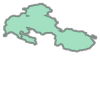

In [19]:
merged = merger.unary_union
merged

In [20]:
#area of new merged polygon
from pyproj import Geod
geod = Geod(ellps="WGS84")
area = abs(geod.geometry_area_perimeter(merged)[0]) / 1000/1000
area

962.8411692189668

In [21]:
large_fires.loc['F13515','geometry'] = merger.unary_union
large_fires.loc['F13515','farea'] = area
large_fires.loc['F13515','startdate'] = merger.startdate.min()
large_fires.loc['F13515','enddate'] = merger.enddate.max()
large_fires = large_fires.drop('F11247')
large_fires = large_fires.sort_values('farea', ascending=False)
large_fires = large_fires.iloc[:20,:]
large_fires

geometry        farea  \
fireid                                                                   
F11445  POLYGON ((-122.59844 39.56282, -122.59844 39.5...  4493.471804   
F11440  MULTIPOLYGON (((-121.52187 44.78768, -121.5218...  1894.388484   
F12649  POLYGON ((-119.48839 37.37486, -119.48839 37.3...  1768.278704   
F11393  POLYGON ((-121.37461 37.38389, -121.37456 37.3...  1526.054850   
F11527  POLYGON ((-120.85137 39.92894, -120.85124 39.9...  1400.560920   
F11529  MULTIPOLYGON (((-122.30420 38.74341, -122.3024...  1264.748675   
F12774  MULTIPOLYGON (((-119.60624 48.23640, -119.6071...  1016.807124   
F13515  POLYGON ((-105.89859 40.61407, -105.89846 40.6...   962.841169   
F11825  POLYGON ((-118.45834 36.26310, -118.45836 36.2...   934.392811   
F12981  MULTIPOLYGON (((-122.23411 44.15412, -122.2341...   804.268938   
F13687  POLYGON ((-106.26332 41.19634, -106.26328 41.1...   772.647843   
F15118  MULTIPOLYGON (((-106.00993 40.31399, -106.0097...   769.787819   
F8251   POLYGON ((-111.49378 33.67996, -111.49715 33.6...   762.470024   
F13066  MULTIPOLYGON (((-123.51933 41.92522, -123.5223...   751.547542   
F10523  POLYGON ((-123.56713 41.18638, -123.56712 41.1...   659.981627   
F12961  MULTIPOLYGON (((-122.30510 45.15745, -122.3045...   622.110247   
F12984  POLYGON ((-122.74770 43.36897, -122.74768 43.3...   597.782801   
F10547  MULTIPOLYGON (((-108.58554 39.29857, -108.5855...   590.420974   
F12731  POLYGON ((-117.96422 34.31876, -117.96422 34.3...   558.087422   
F11716  POLYGON ((-121.66228 36.14966, -121.66229 36.1...   521.979047   

                  startdate              enddate  
fireid                                            
F11445  2020-08-17T00:00:00  2020-11-25T00:00:00  
F11440  2020-08-17T00:00:00  2020-10-29T12:00:00  
F12649  2020-09-05T00:00:00  2020-11-26T00:00:00  
F11393  2020-08-16T12:00:00  2020-09-27T12:00:00  
F11527  2020-08-18T00:00:00  2020-10-29T12:00:00  
F11529  2020-08-18T00:00:00  2020-09-21T12:00:00  
F12774  2020-09-07T00:00:00  2020-10-02T12:00:00  
F13515  2020-08-13T12:00:00  2020-11-13T12:00:00  
F11825  2020-08-20T12:00:00  2020-11-27T00:00:00  
F12981  2019-10-03T00:00:00  2020-10-19T00:00:00  
F13687  2020-09-17T12:00:00  2020-11-06T00:00:00  
F15118  2020-10-14T12:00:00  2021-11-09T12:00:00  
F8251   2020-06-14T00:00:00  2020-07-18T00:00:00  
F13066  2020-09-08T12:00:00  2020-10-29T12:00:00  
F10523  2020-07-31T12:00:00  2020-11-25T12:00:00  
F12961  2020-09-08T00:00:00  2020-10-07T12:00:00  
F12984  2020-09-08T00:00:00  2020-10-11T00:00:00  
F10547  2020-08-01T00:00:00  2020-09-16T00:00:00  
F12731  2020-09-06T12:00:00  2020-10-26T12:00:00  
F11716  2018-08-30T00:00:00  2020-10-21T12:00:00

In [22]:
len(large_fires)

20

In [23]:
large_fires.set_crs("EPSG:4326").explore()

## Add 2km buffer

In [24]:
large_fires_buffered = large_fires.copy()
large_fires_buffered['geometry'] = large_fires.buffer(0.02)
large_fires_buffered.set_crs("EPSG:4326").explore()

## Export to geojson

In [25]:
large_fires.to_file('/projects/shared-buckets/coffield/2020_feds_large_fires.geojson', driver="GeoJSON")  
large_fires_buffered.to_file('/projects/shared-buckets/coffield/2020_feds_large_fires_buffered.geojson', driver="GeoJSON")  